In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.io import loadmat

# Anomaly Detection

In [4]:
data = loadmat('../Data/ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [5]:
X=data['X']
Xval=data['Xval']
yval=data['yval']
X.shape

(307, 2)

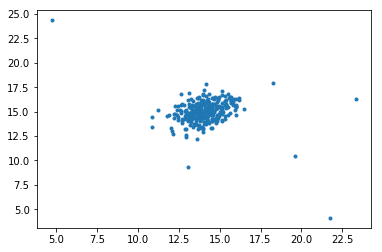

In [6]:
plt.scatter(X[:,0],X[:,1],marker='.')
plt.show()

Looks like some obvious anomalies. Let's see if we can detect them.

In [11]:
mu = X.mean(0)
sigma2 = X.std(0)**2

In [14]:
def gaussian(X,mu,sigma2):
    return np.exp(-(X-mu)**2/(2*sigma2))

In [12]:
p = np.prod(gaussian(X,mu,sigma2),axis=1)

In [17]:
edge = 1
x1,x2 = np.meshgrid(np.linspace(X[:,0].min()-edge,X[:,0].max()+edge,100),np.linspace(X[:,1].min()-edge,X[:,1].max()+edge,100))
prob_map = np.prod(gaussian(np.c_[x1.ravel(),x2.ravel()],mu,sigma2),axis=1).reshape(100,100)

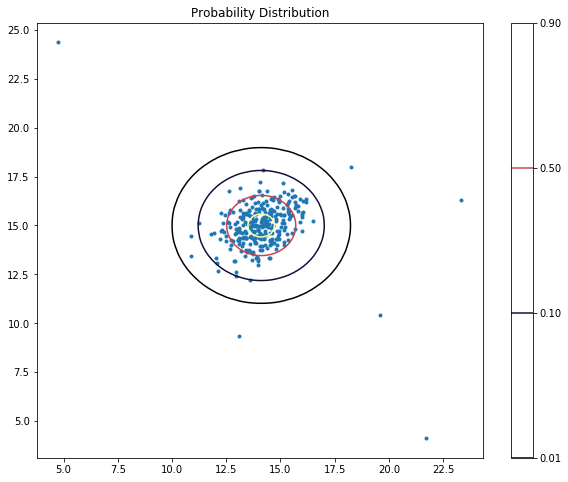

In [27]:
plt.figure(figsize=[10,8])
plt.scatter(X[:,0],X[:,1],marker='.')
plt.contour(x1,x2,prob_map,levels=[.01, .1, .5, .9], cmap=plt.get_cmap('inferno'))
plt.colorbar()
plt.title('Probability Distribution')
plt.show()

Just from this image, it seems pretty safe to set epsilon to be 0.01, but let's see what sort of procedure the instructions walk us through. However, this set of data isn't *supposed* to have anomalies, as they're supposed to be in the validation data.

In [28]:
pval = np.prod(gaussian(Xval,mu,sigma2),axis=1)

In [69]:
granularity = 6
eps_list = [10**(i/granularity) for i in range(-5*granularity,-3*granularity)]
fScoreList = []
for ie, eps in enumerate(eps_list):
    yGuess = pval<eps
    precision = sum(yGuess&yval.ravel())/sum(yGuess)
    recall = sum(yGuess&yval.ravel())/np.sum(yval)
    fScoreList.append(2*precision*recall/(precision+recall))

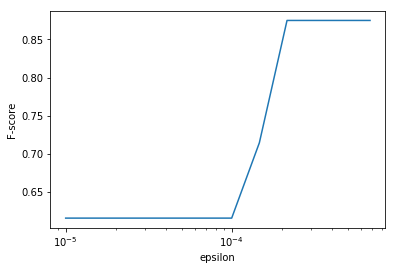

In [70]:
plt.plot(eps_list,fScoreList)
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('F-score')
plt.show()